# Shapley Value Approximation

## Data Acquisition 

In [1]:
import numpy as np

import sklearn as sk
from sklearn import *

from pydvl.utils import Dataset, Utility
from pydvl.utils import Dataset
from pydvl.reporting.plots import plot_shapley
from pydvl.utils.dataset import GroupedDataset
from pydvl.value import *

import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

dataset = Dataset.from_sklearn(datasets.load_iris())
model = neighbors.KNeighborsClassifier(n_neighbors=3)
utility = Utility(model, dataset)
n = utility.data.x_train.shape[0]

ImportError: DLL load failed while importing _multiarray_umath: 找不到指定的模块。

ImportError: DLL load failed while importing _multiarray_umath: 找不到指定的模块。

(CVXPY) Oct 10 05:28:54 PM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy._core.multiarray failed to import')


ImportError: DLL load failed while importing _multiarray_umath: 找不到指定的模块。

(CVXPY) Oct 10 05:28:54 PM: Encountered unexpected exception importing solver SCS:
ImportError('numpy._core.multiarray failed to import')


ImportError: DLL load failed while importing _multiarray_umath: 找不到指定的模块。

(CVXPY) Oct 10 05:28:54 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy._core.multiarray failed to import')


ImportError: DLL load failed while importing _multiarray_umath: 找不到指定的模块。

(CVXPY) Oct 10 05:28:54 PM: Encountered unexpected exception importing solver OSQP:
ImportError('numpy._core.multiarray failed to import')


In [2]:
# dataset = Dataset.from_sklearn(datasets.load_diabetes())
# model = linear_model.LogisticRegression()
# utility = Utility(model, dataset)
# n = utility.data.x_train.shape[0]

## Truncated Monte Carlo Approximation

In [3]:
tmc_values = compute_shapley_values(
    utility,
    mode = ShapleyMode.TruncatedMontecarlo,
    # Stop if the standard error is below 1% of the range of the values (which is ~2),
    # or if the number of updates exceeds 1000
    done=AbsoluteStandardError(threshold=0.05, fraction=0.9) | MaxUpdates(1000),
    truncation=RelativeTruncation(utility, rtol=0.001),
    n_jobs=-1,
)
#values.sort(key="value")
tmc_shapley_value = tmc_values.to_dataframe(column="data_value", use_names=True)

c:\Users\666\anaconda3\envs\python\lib\site-packages\pydvl\parallel\backends\joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(


In [4]:
tmc_shapley_value

,data_value,data_value_stderr,data_value_updates
0,0.000000,0.000000,5
1,0.046667,0.041740,5
2,0.053333,0.047703,5
3,0.000000,0.000000,5
4,0.000000,0.000000,5
...,...,...,...
115,0.000000,0.000000,5
116,0.000000,0.000000,5
117,0.033333,0.029814,5
118,0.000000,0.000000,5


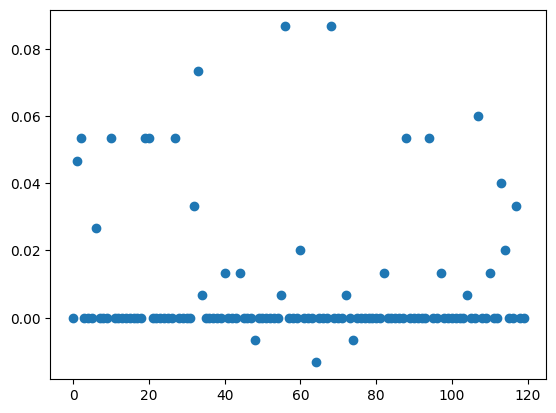

In [5]:
plt.scatter(range(n),tmc_shapley_value.data_value)
plt.show()

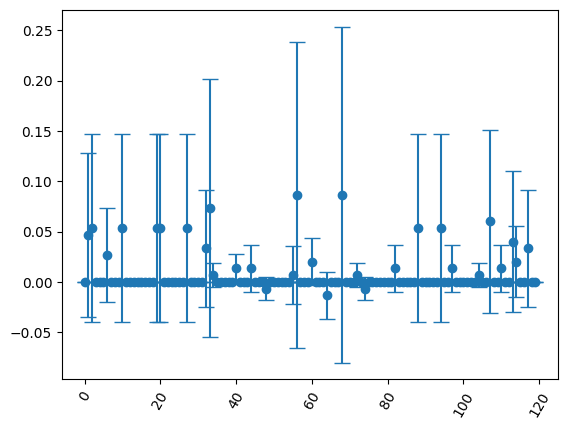

In [6]:
plot_shapley(tmc_shapley_value)
plt.show()

## Beta Shapley Value

In [7]:
ValuationResult = compute_beta_shapley_semivalues(
    u=utility,
    alpha=1,
    beta=1,
    done=AbsoluteStandardError(threshold=0.05, fraction=0.9) | MaxUpdates(1000),
    sampler_t=PermutationSampler,
    batch_size=128,
    n_jobs=1
)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
c:\Users\666\anaconda3\envs\python\lib\site-packages\pydvl\parallel\backends\joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(


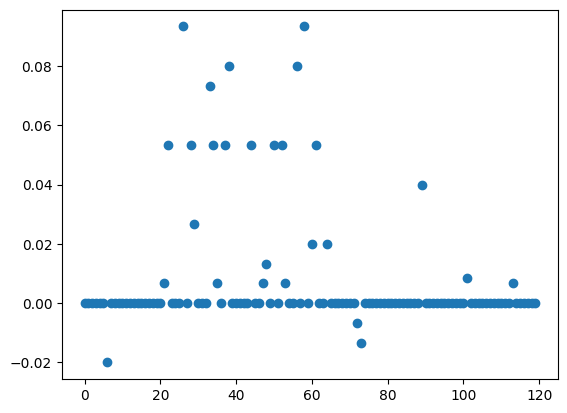

In [8]:
beta_result = ValuationResult.to_dataframe(column="data_value", use_names=True)
plt.scatter(range(n),beta_result.data_value)
plt.show()

## CS Shapley Value

## Owen Sampling

## KNN SV

In [9]:
dataset = Dataset.from_sklearn(datasets.load_diabetes())
model = sk.neighbors.KNeighborsClassifier(n_neighbors=3)
utility = Utility(model, dataset)

In [10]:
knn_result = knn_shapley(utility,progress=True)
knn_result = knn_result.to_dataframe(column="data_value", use_names=True)


c:\Users\666\anaconda3\envs\python\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


0it [00:00, ?it/s]

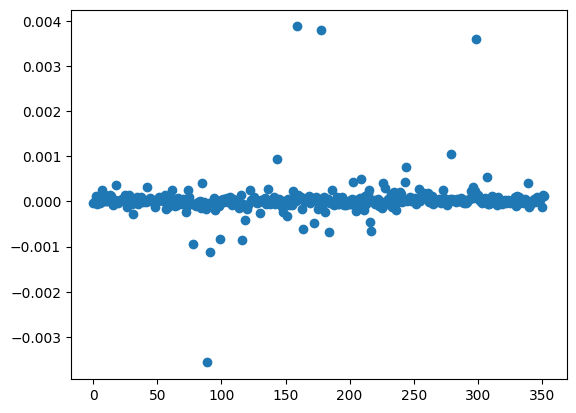

In [11]:
plt.scatter(range(len(knn_result.data_value)),knn_result.data_value)
plt.show()

## Compresive SV

In [12]:
import numpy as np
import cvxpy as cp
from concurrent.futures import ThreadPoolExecutor

def compute_phi(i, utility, permutation):
    """ 计算数据点 i 的边际贡献 phi。 """
    U_with_i = utility(permutation[:i + 1])  # 加入i后的效用
    U_without_i = utility(permutation[:i])     # 未加入i时的效用
    return U_with_i - U_without_i

def compressive_permutation_sampling(utility, M, T):
    """
    压缩感知置换采样计算Shapley Value.
    
    参数：
    utility - 可调用对象，负责对训练数据子集重新训练并计算效用
    M - 伯努利矩阵A的行数，压缩感知测量数
    T - 随机置换次数
    
    返回：
    训练集中每个数据点的Shapley Value估计
    """
    N = len(utility.data.x_train)  # 数据点个数
    
    # 生成伯努利矩阵A
    A = np.random.choice([-1/np.sqrt(M), 1/np.sqrt(M)], size=(M, N))
    
    y_hat = np.zeros((M, T))
    
    for t in range(T):
        print(f"Iteration: {t+1}/{T}")
        
        permutation = np.random.permutation(N)
        
        phi_t = np.zeros(N)
        
        # 使用ThreadPoolExecutor并行计算phi_t
        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(compute_phi, i, utility, permutation): i for i in range(N)}
            for future in futures:
                i = futures[future]
                phi_t[i] = future.result()
        
        # 对每个m，计算y_hat[m, t]
        for m in range(M):
            y_hat[m, t] = np.dot(A[m, :], phi_t)
    
    y_bar = np.mean(y_hat, axis=1)
    
    U_D = utility(permutation)  # 整个数据集的效用
    s_bar = U_D / N
    
    delta_s = cp.Variable(N)  # 定义变量 delta_s
    epsilon = 1e-6  # 允许的误差范围
    
    # 目标：最小化 L1 范数 ||Δs||_1
    objective = cp.Minimize(cp.norm1(delta_s))
    
    # 约束：||A(s_bar + Δs) - y_bar||_2 <= epsilon
    constraints = [cp.norm2(A @ (s_bar + delta_s) - y_bar) <= epsilon]
    
    # 定义并求解优化问题
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status in ["infeasible", "unbounded"]:
        print("优化失败！返回初始估计。")
        delta_s_value = np.zeros(N)
    else:
        delta_s_value = delta_s.value

    # 最终Shapley Value估计
    s_hat = s_bar + delta_s_value
    return s_hat

# 参数设置
M = 5  # 压缩感知测量数
T = 100
# 计算Shapley Value
cp_shapley_values = compressive_permutation_sampling(utility, M, T)

print("Shapley Values:", cp_shapley_values)
plt.scatter(range(n),cp_shapley_values)
plt.show()

Iteration: 1/100
Iteration: 2/100
Iteration: 3/100
Iteration: 4/100
Iteration: 5/100
Iteration: 6/100
Iteration: 7/100
Iteration: 8/100
Iteration: 9/100
Iteration: 10/100
Iteration: 11/100
Iteration: 12/100
Iteration: 13/100
Iteration: 14/100
Iteration: 15/100
Iteration: 16/100
Iteration: 17/100
Iteration: 18/100
Iteration: 19/100
Iteration: 20/100
Iteration: 21/100
Iteration: 22/100
Iteration: 23/100
Iteration: 24/100
Iteration: 25/100
Iteration: 26/100
Iteration: 27/100
Iteration: 28/100
Iteration: 29/100
Iteration: 30/100
Iteration: 31/100
Iteration: 32/100
Iteration: 33/100
Iteration: 34/100
Iteration: 35/100
Iteration: 36/100
Iteration: 37/100
Iteration: 38/100
Iteration: 39/100
Iteration: 40/100
Iteration: 41/100
Iteration: 42/100
Iteration: 43/100
Iteration: 44/100
Iteration: 45/100
Iteration: 46/100
Iteration: 47/100
Iteration: 48/100
Iteration: 49/100
Iteration: 50/100
Iteration: 51/100
Iteration: 52/100
Iteration: 53/100
Iteration: 54/100
Iteration: 55/100
Iteration: 56/100
I

ImportError: cannot import name '_cvxcore' from 'cvxpy.cvxcore.python' (c:\Users\666\anaconda3\envs\python\lib\site-packages\cvxpy\cvxcore\python\__init__.py)

## Gradient SV

In [ ]:
from DShap import DShap
model = 'logistic'
problem = 'classification'
num_test = 1000
directory = './temp'
dshap = DShap(utility.data.x_train.astype(float), 
              utility.data.y_train.astype(int), 
              utility.data.x_test.astype(float), 
              utility.data.y_test.astype(int), 
              num_test, 
              sources=None, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
dshap.run(100, 0.1, g_run=True)
dshap.run(100, 0.1, g_run=False,loo_run=False)
dshap.merge_results()
dshap.marginals_g
tmc = np.mean(dshap.marginals_tmc,0)
plt.scatter(range(n),tmc)
plt.show()

g_sv = np.mean(dshap.marginals_g,0)
plt.scatter(range(n),g_sv)
plt.show()